# Imports

In [15]:
!pip install torchmetrics matplotlib seaborn scikit-learn

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import Adam
import torchmetrics
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset ,DataLoader, WeightedRandomSampler, random_split
from torch.utils.data.dataset import Subset
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image

import os
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns

# Dataset Class Definition for Non-Series Dataset

In this section, we define a custom dataset class `AlzheimerDataset` for handling the Alzheimer's MRI images dataset. Each image in this dataset is treated as an individual sample. This class is crucial for loading the images and their corresponding labels efficiently during the training and evaluation of our deep learning models. It allows us to apply transformations to the dataset images and prepare them for input into the neural network.

### Data Augmentation and DataLoader Preparation

In this section, we initialize the dataset and then apply data augmentation techniques to increase the diversity of our dataset, which can lead to better model generalization. After initializing the Alzheimer's dataset class, we split the dataset into training, validation, and test sets. To address the issue of class imbalance, we calculate class weights and utilize these weights to create a weighted sampler for the training data. Finally, we prepare DataLoader objects for each subset of the dataset to facilitate efficient data loading during the model training and evaluation phases.

To effectively handle class imbalance, we employ a weight rebalancing strategy that ensures less frequent classes are given more importance during training. This is accomplished through the following steps:

1. **Calculate Class Sample Counts**: We compute the number of samples for each class in the dataset. This count helps in identifying the extent of imbalance and determining the appropriate weight that each class should receive.

2. **Compute Class Weights**: For each class, the weight is calculated as the inverse of its sample count. This method assigns higher weights to less frequent classes, thus amplifying their presence during the training process.

3. **Assign Sample Weights**: Each sample in the dataset is then assigned a weight corresponding to its class weight. This results in a weighted distribution where the significance of each sample is adjusted according to its weight.

4. **Weighted Random Sampler**: In the training DataLoader, a WeightedRandomSampler is used with these sample weights. This sampler ensures that data batches are selected in a manner that reflects the assigned weights, providing more representation to underrepresented classes and mitigating the effects of class imbalance.

By applying these steps, we ensure that the training process accounts for all classes equitably, preventing the model from biasing towards the majority classes and thereby achieving a more balanced and accurate prediction across all classes.


In [17]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image categories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        for category in categories:
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                self.image_paths.append(os.path.join(category_path, img_name))
                self.labels.append(label_mapping[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize the full dataset without transforms
full_dataset = AlzheimerDataset(root_dir='Data')

# Stratify split the dataset
np_labels = np.array(full_dataset.labels)
train_idx, val_test_idx = train_test_split(np.arange(len(np_labels)), test_size=0.3, stratify=np_labels, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, stratify=np_labels[val_test_idx], random_state=42)

# Create and transform subsets
train_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=train_transforms), train_idx)
val_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=val_test_transforms), val_idx)
test_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=val_test_transforms), test_idx)

# Calculate and apply class weights
class_weights = [1.0 / np.sum(np_labels == i) for i in range(4)]
weights = torch.DoubleTensor([class_weights[label] for label in np_labels[train_idx]])
train_sampler = WeightedRandomSampler(weights, len(weights))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Defining a Common Training Function for All Models

In this section, we define a universal training function that can be applied to all models since they share common inputs and outputs. This function will handle the model training and validation processes, including features like saving model checkpoints, tracking training and validation metrics, and optionally performing parameter search to find the optimal model configuration. The use of a common training function streamlines the training process across different models, ensuring consistency and reducing code redundancy.

In [18]:
def save_performance_metrics(performance_data, model_dir, filename):
    """
    Saves performance metrics to a JSON file.
    """
    filepath = os.path.join(model_dir, filename)
    with open(filepath, 'w') as file:
        json.dump(performance_data, file)
    print(f"Metrics saved to {filepath}")

def save_model_checkpoint(model, model_dir, filename):
    """
    Saves the model checkpoint to a file.
    """
    filepath = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def handle_keyboard_interrupt(model, model_dir, performance_data, last_epoch, epoch,adv=False):
    """
    Handles keyboard interrupt by saving the current model state and performance metrics.
    """
    model_filename = 'interrupted.pth' if not adv else 'adv_interrupted.pth'
    performance_filename = f'interrupted_performance_{last_epoch+1}_{epoch+1}.json'
    save_model_checkpoint(model, model_dir, model_filename)
    save_performance_metrics(performance_data, model_dir, performance_filename)

In [19]:
def train_model(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, load_pretrained=False, last_epoch=-1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_f1score = 0
    best_val_loss = float('inf')

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    # Setup metrics
    val_f1_score = torchmetrics.F1Score(num_classes=4, average='macro', task='multiclass').to(device)
    val_accuracy = torchmetrics.Accuracy(num_classes=4, task='multiclass').to(device)


    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and last_epoch >= 0:
        checkpoint_path = os.path.join(model_save_dir, f'epoch_{last_epoch}.pth')
        if os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"Loaded checkpoint from {checkpoint_path}")

    try:
        for epoch in range(last_epoch + 1, last_epoch + 1 + epochs):
            model.train()
            total_train_loss = 0

            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            val_f1_score.reset()
            val_accuracy.reset()

            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device)
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    total_val_loss += loss.item()

                    predictions = outputs.argmax(dim=1)
                    val_f1_score.update(predictions, targets)
                    val_accuracy.update(predictions, targets)

            avg_val_loss = total_val_loss / len(val_loader)
            current_val_f1score = val_f1_score.compute().item()
            current_val_accuracy = val_accuracy.compute().item()
            val_loss_history.append(avg_val_loss)
            val_accuracy_history.append(current_val_accuracy)
            val_f1score_history.append(current_val_f1score)

            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1 Score: {current_val_f1score:.4f}, Val Accuracy: {current_val_accuracy:.4f}")

            # Save model if improved
            if current_val_f1score > best_val_f1score or avg_val_loss < best_val_loss:
                save_model_checkpoint(model, model_save_dir, f'epoch_{epoch}.pth')
                best_val_f1score = current_val_f1score
                best_val_loss = avg_val_loss

        # Save metrics at the end of training
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        save_performance_metrics(performance_data, model_save_dir, 'final_performance_metrics.json')

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        handle_keyboard_interrupt(model, model_save_dir, performance_data, last_epoch, epoch)
        print("All state saved after interruption.")

# Defining and Training the Regular CNN Model

In this section, we define a convolutional neural network (CNN) model with batch normalization and dropout layers to prevent overfitting and ensure more robust learning. The model comprises three convolutional layers, each followed by batch normalization, a max-pooling layer, and dropout. After the convolutional layers, the data is flattened and passed through three fully connected layers with dropout between them. This architecture is designed to learn the hierarchical features from the Alzheimer's MRI images for the classification task.


In [6]:
# Load pre-trained ResNet model
resnet = models.resnet50()

# Modify the first convolutional layer to accept one channel
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer to output 4 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 4)  # Assuming 4 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training the BatchNormDropOutCNN Model

In this part of the notebook, we initialize and train the `BatchNormDropOutCNNModel` using our defined training function. We set up the model checkpoint path and model name, instantiate the model, and move it to the appropriate device (GPU if available, otherwise CPU). The model is then trained for a specified number of epochs (in this case, 200), and the performance indicators such as training loss, validation loss, training accuracy, and validation accuracy are tracked and printed. This process provides a comprehensive view of the model's performance over the training period, helping us to evaluate its effectiveness in classifying Alzheimer's disease stages from MRI images.


In [ ]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'ResNet'

# Train the model
performance_indicators = train_model(
    resnet, 
    train_loader, 
    val_loader, 
    device, 
    model_checkpoint_path, 
    model_name, 
    epochs=200, 
    load_pretrained=False, 
    last_epoch=-1)
print(performance_indicators)

Epoch 1, Train Loss: 0.6035, Val Loss: 1.3529, Val F1 Score: 0.3706, Val Accuracy: 0.4828
Model saved to DebuggedModelCheckpoints/ResNet/epoch_0.pth
Epoch 2, Train Loss: 0.3466, Val Loss: 0.5261, Val F1 Score: 0.6754, Val Accuracy: 0.7681
Model saved to DebuggedModelCheckpoints/ResNet/epoch_1.pth
Epoch 3, Train Loss: 0.2561, Val Loss: 0.6631, Val F1 Score: 0.7709, Val Accuracy: 0.7658
Model saved to DebuggedModelCheckpoints/ResNet/epoch_2.pth
Epoch 4, Train Loss: 0.1998, Val Loss: 0.4204, Val F1 Score: 0.8347, Val Accuracy: 0.8317
Model saved to DebuggedModelCheckpoints/ResNet/epoch_3.pth
Epoch 5, Train Loss: 0.1549, Val Loss: 0.3774, Val F1 Score: 0.8108, Val Accuracy: 0.8524
Model saved to DebuggedModelCheckpoints/ResNet/epoch_4.pth
Epoch 6, Train Loss: 0.1233, Val Loss: 0.6318, Val F1 Score: 0.6995, Val Accuracy: 0.8230
Epoch 7, Train Loss: 0.1013, Val Loss: 0.3241, Val F1 Score: 0.8892, Val Accuracy: 0.8788
Model saved to DebuggedModelCheckpoints/ResNet/epoch_6.pth
Epoch 8, Train L

In [8]:
model_checkpoint_path = 'DebuggedModelCheckpoints'
model_name = 'ResNet'

# Train the model
performance_indicators = train_model(
    resnet, 
    train_loader, 
    val_loader, 
    device, 
    model_checkpoint_path, 
    model_name, 
    epochs=73, 
    load_pretrained=True, 
    last_epoch=23)
print(performance_indicators)

Loaded checkpoint from DebuggedModelCheckpoints/ResNet/epoch_23.pth
Epoch 25, Train Loss: 0.0179, Val Loss: 0.0079, Val F1 Score: 0.9966, Val Accuracy: 0.9971
Model saved to DebuggedModelCheckpoints/ResNet/epoch_24.pth
Epoch 26, Train Loss: 0.0186, Val Loss: 0.0120, Val F1 Score: 0.9954, Val Accuracy: 0.9958
Epoch 27, Train Loss: 0.0158, Val Loss: 0.0075, Val F1 Score: 0.9973, Val Accuracy: 0.9977
Model saved to DebuggedModelCheckpoints/ResNet/epoch_26.pth
Epoch 28, Train Loss: 0.0176, Val Loss: 0.0165, Val F1 Score: 0.9900, Val Accuracy: 0.9940
Epoch 29, Train Loss: 0.0152, Val Loss: 0.0194, Val F1 Score: 0.9855, Val Accuracy: 0.9931
Epoch 30, Train Loss: 0.0131, Val Loss: 0.0252, Val F1 Score: 0.9915, Val Accuracy: 0.9916
Epoch 31, Train Loss: 0.0148, Val Loss: 0.0095, Val F1 Score: 0.9957, Val Accuracy: 0.9966
Epoch 32, Train Loss: 0.0142, Val Loss: 0.0157, Val F1 Score: 0.9921, Val Accuracy: 0.9944
Epoch 33, Train Loss: 0.0120, Val Loss: 0.0271, Val F1 Score: 0.9877, Val Accuracy: 

# Final Model Evaluation on Test Data

After determining the best-performing epochs from both standard and adversarial training, the next step is to evaluate these selected models on the test dataset. This evaluation will give us an understanding of the models' performance in a real-world scenario, where they are exposed to unseen data.

We load the model states from the best epochs identified during the validation phase and then assess their performance on the test set. This process helps in quantifying the effectiveness of the training and provides a more comprehensive view of how well the models generalize beyond the training and validation datasets.

The results from this evaluation are crucial for comparing the standard and adversarially trained models, enabling us to make informed decisions regarding the deployment of these models in practical applications.


In [25]:
import os
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for calculations

def validate(model, val_loader, num_classes, adv=False):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Compute the metrics
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Print the results
    print(f'Model - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Macro: {f1_macro:.4f}')

    # Calculate and normalize the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize each row to sum to 1

    print('Confusion Matrix:')
    # print(cm_percentage)  # Display the percentage matrix

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for RESNET Model')
    plt.show()

    return

Training Set Evaluation:
Model - Loss: 0.0044, Accuracy: 0.9984, F1 Macro: 0.9984
Confusion Matrix:


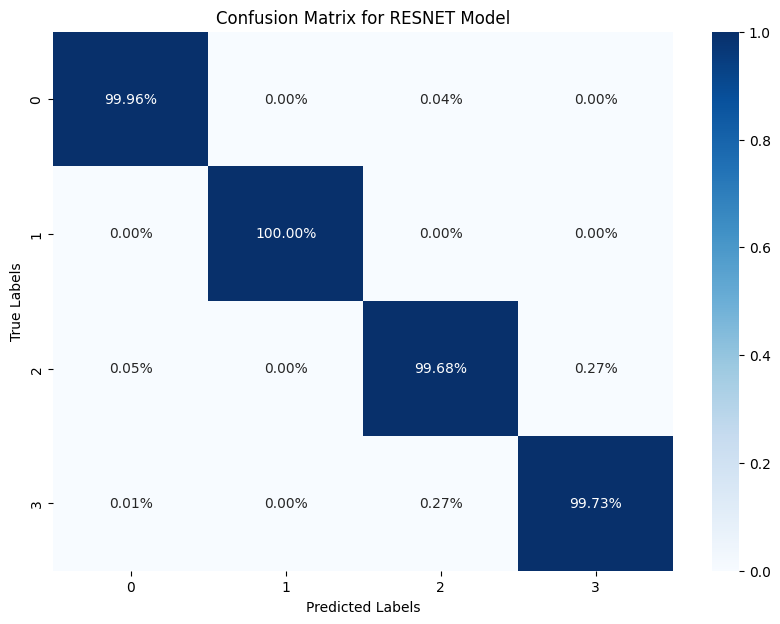

Validation Set Evaluation:
Model - Loss: 0.0075, Accuracy: 0.9977, F1 Macro: 0.9973
Confusion Matrix:


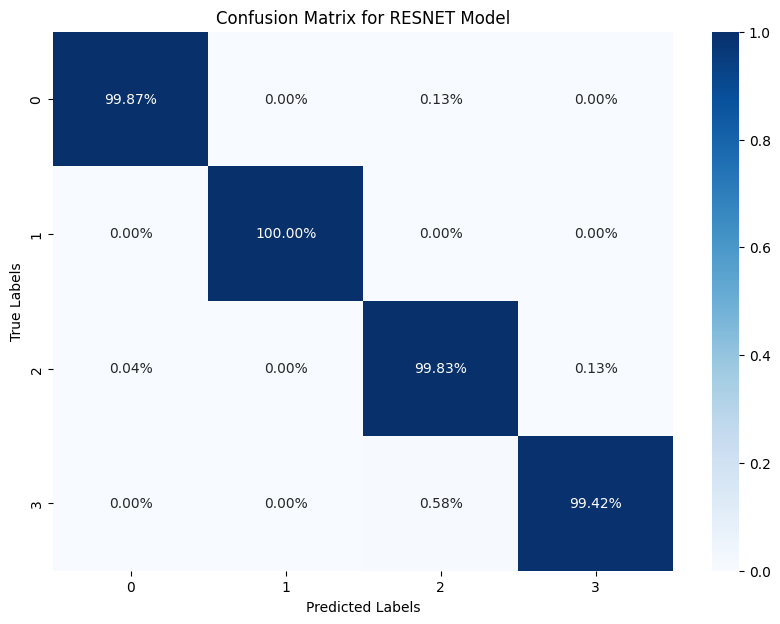

Test Set Evaluation:
Model - Loss: 0.0073, Accuracy: 0.9977, F1 Macro: 0.9969
Confusion Matrix:


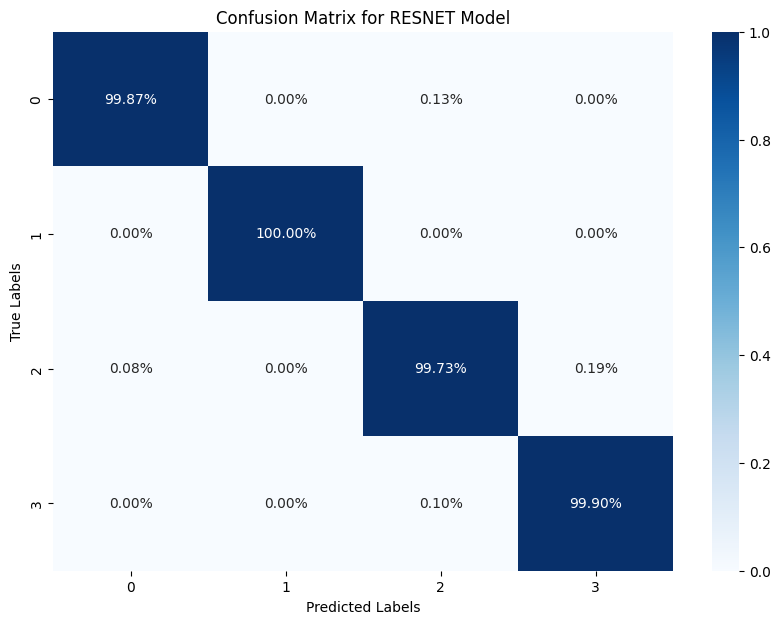

In [26]:
# Load the best performing model from standard training and evaluate on test data
path = f'DebuggedModelCheckpoints/ResNet/epoch_{26}.pth'

resnet = models.resnet50()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.load_state_dict(torch.load(path, map_location=device))


resnet.to(device)

print("Training Set Evaluation:")
validate(resnet,train_loader,4)
print("Validation Set Evaluation:")
validate(resnet,val_loader,4)
print("Test Set Evaluation:")
validate(resnet,test_loader,4)